# Solution 1:

### Part 1:

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from scipy.linalg import sqrtm
from sklearn.datasets import make_spd_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [171]:
mu = [[2, 2, 0], [-2, 2, 0], [-2, -2, 0], [2, -2, 0]]
var_1 = make_spd_matrix(3)
var_2 = make_spd_matrix(3)
var_3 = make_spd_matrix(3)
var_4 = make_spd_matrix(3)
prior = [0.30, 0.25, 0.35, 0.10]

N_1 = 1000
N_2 = 10000

In [172]:
#generating number of sample for the GMMs
def sample_number(N):
    l_1 = 0
    l_2 = 0
    l_3 = 0
    l_4 = 0

    for i in range(N):
        temp = np.random.uniform(0, 1, 1)
        if temp <= prior[0]:
            l_1 = l_1 + 1
        elif temp <= prior[0] + prior[1]:
            l_2 = l_2 + 1
        elif temp <= prior[0] + prior[1] + prior[2]:
            l_3 = l_3 + 1

    l_4 = N - l_1 - l_2 - l_3
    return l_1, l_2, l_3, l_4

In [173]:
#generating data
def data_generator(l_1, l_2, l_3, l_4, mu, var_1, var_2, var_3, var_4):
    data = []
    data_1 = []
    data_2 = []
    data_3 = []
    data_4 = []
    true_label = []
    true_prob = []
    N = l_1 + l_2 + l_3 + l_4

    for i in range(l_1):
        temp = np.random.multivariate_normal(mu[0], var_1, 1)
        data_1.append(temp)
        data.append(temp)
        true_label.append([1])
        true_prob.append([1, 0, 0, 0])
    data_1 = np.array(data_1).reshape((l_1, 3))

    for i in range(l_2):
        temp = np.random.multivariate_normal(mu[1], var_2, 1)
        data_2.append(temp)
        data.append(temp)
        true_label.append([2])
        true_prob.append([0, 1, 0, 0])
    data_2 = np.array(data_2).reshape((l_2, 3))

    for i in range(l_3):
        temp = np.random.multivariate_normal(mu[2], var_3, 1)
        data_3.append(temp)
        data.append(temp)
        true_label.append([3])
        true_prob.append([0, 0, 1, 0])
    data_3 = np.array(data_3).reshape((l_3, 3))

    for i in range(l_4):
        temp = np.random.multivariate_normal(mu[3], var_4, 1)
        data_4.append(temp)
        data.append(temp)
        true_label.append([4])
        true_prob.append([0, 0, 0, 1])
    data_4 = np.array(data_4).reshape((l_4, 3))

    data = np.array(data).reshape((N, 3))
    true_prob = np.array(true_prob).reshape((N, 4))
    true_label = np.array(true_label).reshape((N, 1))

    return data, data_1, data_2, data_3, data_4, true_label, true_prob

In [174]:
l_1, l_2, l_3, l_4 = sample_number(N_1)
data, data_1, data_2, data_3, data_4, true_label, true_prob = data_generator(l_1, l_2, l_3, l_4, mu, var_1, var_2, var_3, var_4)

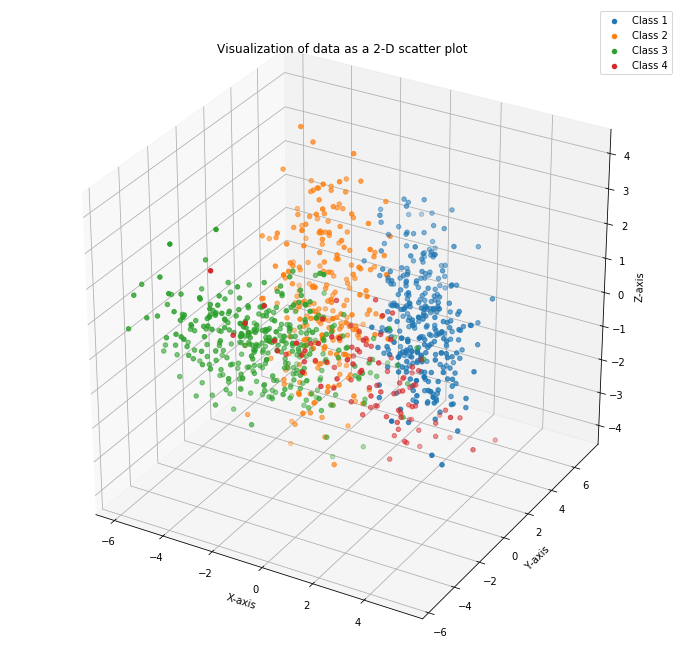

In [175]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_1[:, 0], data_1[:, 1], data_1[:, 2], label='Class 1')
ax.scatter(data_2[:, 0], data_2[:, 1], data_2[:, 2], label='Class 2')
ax.scatter(data_3[:, 0], data_3[:, 1], data_3[:, 2], label='Class 3')
ax.scatter(data_4[:, 0], data_4[:, 1], data_4[:, 2], label='Class 4')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.title('Visualization of data as a 2-D scatter plot')
ax.legend()
plt.show()

### Points to note:
1) The application required that the covariance matrices be symmetric and positive definite for apropriate values of the data points (they were in the gaussian distribution). Hence, to generate such matrices, I have made use of the sklearn.datasets.make_spd_matrix package of sklearn. This package takes the dimensions of the required matrices as arguments and returns a random symmetric, positive-definite matrix.

2) Generation of data: Data is generated in two steps:

Step 1: The number of dataset pairs is calculated of each class using the priors declared (priors are 0.30, 0.25, 0.35, 0.10 for classes 1, 2, 3, and 4 respectively). Uniform distribution is used here to determine the number of pairs for each class.

Step 2: The data is generated according to Gaussian distribution into four classes based on the size of each class determined from the previos step. The samples are generated according to the conditions mentioned in the question. The means of each of the classes are taken as [2, 2, 0], [-2, 2, 0], [-2, -2, 0], [2, -2, 0] for classes 1, 2, 3, and 4 respectively. This gives a theoretical minimum probability of error between 4-15%. The exact values varies depending on the values generated for the covariences (which are randomly generated as mentioned in point 1).

### Part 2:

In [176]:
l_1, l_2, l_3, l_4 = sample_number(N_2)
data, data_1, data_2, data_3, data_4, true_label, true_prob = data_generator(l_1, l_2, l_3, l_4, mu, var_1, var_2, var_3, var_4)

In [177]:
l_1, l_2, l_3, l_4

(3021, 2535, 3444, 1000)

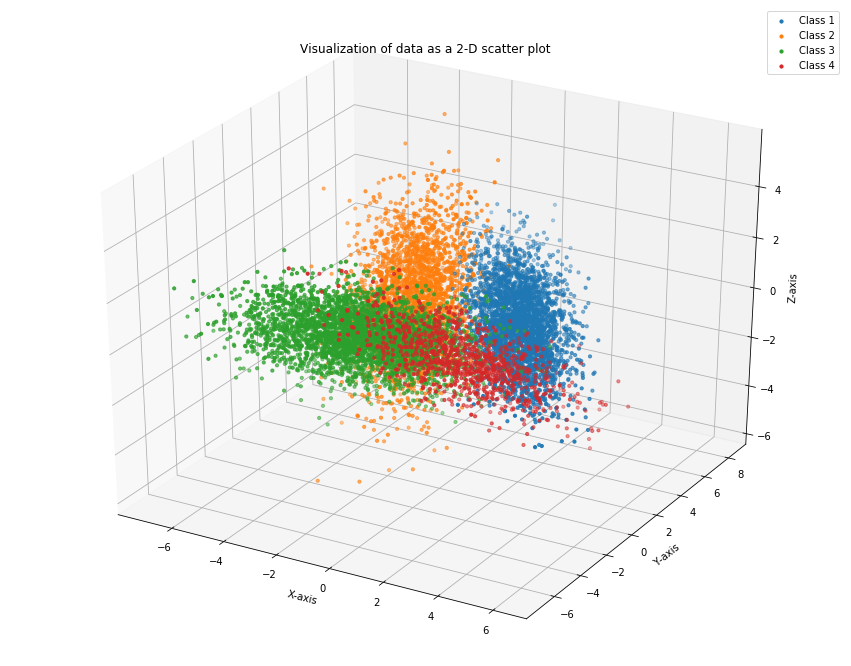

In [178]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_1[:, 0], data_1[:, 1], data_1[:, 2], s=10, label='Class 1')
ax.scatter(data_2[:, 0], data_2[:, 1], data_2[:, 2], s=10, label='Class 2')
ax.scatter(data_3[:, 0], data_3[:, 1], data_3[:, 2], s=10, label='Class 3')
ax.scatter(data_4[:, 0], data_4[:, 1], data_4[:, 2], s=10, label='Class 4')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.title('Visualization of data as a 2-D scatter plot')
ax.legend()
plt.show()

In [179]:
def normal_prob(x, m, v):
    x_t = x
    m_t = m
    x = np.reshape(x, (3,1))
    m = np.reshape(m, (3,1))
    p = math.exp(-0.5*np.matmul(np.matmul((x_t-m_t), np.linalg.inv(v)), (x-m)))/(2*math.pi*np.linalg.det(v))
    return p

In [180]:
correct_1 = []
error_1 = []

correct_2 = []
error_2 = []

correct_3 = []
error_3 = []

correct_4 = []
error_4 = []


for i in range(l_1):
    p_1 = normal_prob(data_1[i, :], mu[0], var_1)*prior[0]
    p_2 = normal_prob(data_1[i, :], mu[1], var_2)*prior[1]
    p_3 = normal_prob(data_1[i, :], mu[2], var_3)*prior[2]
    p_4 = normal_prob(data_1[i, :], mu[3], var_4)*prior[3]
    if p_1 >= max(p_2, p_3, p_4):
        correct_1.append(data_1[i, :])
    else:
        error_1.append(data_1[i, :])
correct_1 = np.array(correct_1)
error_1 = np.array(error_1)
    
for i in range(l_2):
    p_1 = normal_prob(data_2[i, :], mu[0], var_1) * prior[0]
    p_2 = normal_prob(data_2[i, :], mu[1], var_2) * prior[1]
    p_3 = normal_prob(data_2[i, :], mu[2], var_3) * prior[2]
    p_4 = normal_prob(data_2[i, :], mu[3], var_4) * prior[3]
    if max(p_1, p_2, p_3, p_4) == p_2:
        correct_2.append(data_2[i, :])
    else:
        error_2.append(data_2[i, :])
correct_2 = np.array(correct_2)
error_2 = np.array(error_2)
        
for i in range(l_3):
    p_1 = normal_prob(data_3[i, :], mu[0], var_1) * prior[0]
    p_2 = normal_prob(data_3[i, :], mu[1], var_2) * prior[1]
    p_3 = normal_prob(data_3[i, :], mu[2], var_3) * prior[2]
    p_4 = normal_prob(data_3[i, :], mu[3], var_4) * prior[3]
    if max(p_1, p_2, p_3, p_4) == p_3:
        correct_3.append(data_3[i, :])
    else:
        error_3.append(data_3[i, :])
correct_3 = np.array(correct_3)
error_3 = np.array(error_3)
        
for i in range(l_4):
    p_1 = normal_prob(data_4[i, :], mu[0], var_1) * prior[0]
    p_2 = normal_prob(data_4[i, :], mu[1], var_2) * prior[1]
    p_3 = normal_prob(data_4[i, :], mu[2], var_3) * prior[2]
    p_4 = normal_prob(data_4[i, :], mu[3], var_4) * prior[3]
    if max(p_1, p_2, p_3, p_4) == p_4:
        correct_4.append(data_4[i, :])
    else:
        error_4.append(data_4[i, :])
correct_4 = np.array(correct_4)
error_4 = np.array(error_4)

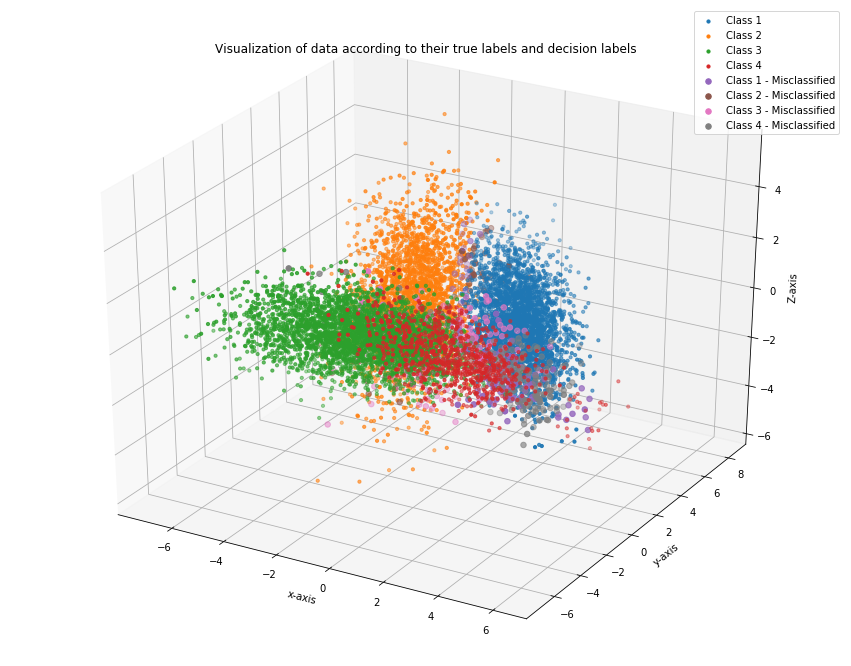

In [181]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(correct_1[:, 0], correct_1[:, 1], correct_1[:, 2], s=10, label='Class 1')
ax.scatter(correct_2[:, 0], correct_2[:, 1], correct_2[:, 2], s=10, label='Class 2')
ax.scatter(correct_3[:, 0], correct_3[:, 1], correct_3[:, 2], s=10, label='Class 3')
ax.scatter(correct_4[:, 0], correct_4[:, 1], correct_4[:, 2], s=10, label='Class 4')
if len(error_1) > 0:
    ax.scatter(error_1[:, 0], error_1[:, 1], error_1[:, 2], s=30, label='Class 1 - Misclassified')
if len(error_2) > 0:
    ax.scatter(error_2[:, 0], error_2[:, 1], error_2[:, 2], s=30, label='Class 2 - Misclassified')
if len(error_3) > 0:
    ax.scatter(error_3[:, 0], error_3[:, 1], error_3[:, 2], s=30, label='Class 3 - Misclassified')
if len(error_4) > 0:
    ax.scatter(error_4[:, 0], error_4[:, 1], error_4[:, 2], s=30, label='Class 4 - Misclassified')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
ax.set_zlabel('Z-axis')
plt.title('Visualization of data according to their true labels and decision labels')
ax.legend()
plt.show()

In [182]:
print("\nThe total number of samples misclassified by the classifier are {}".format(len(error_1) + len(error_2) + len(error_3) + len(error_4)))

print("\nThe error probability is {}.".format((len(error_1) + len(error_2) + len(error_3) + len(error_4))/N_2))


The total number of samples misclassified by the classifier are 642

The error probability is 0.0642.


In [183]:
print("Wrongly classified points from class 1: {}". format(len(error_1)))
print("Wrongly classified points from class 1: {}". format(len(error_2)))
print("Wrongly classified points from class 1: {}". format(len(error_3)))
print("Wrongly classified points from class 1: {}". format(len(error_4)))

Wrongly classified points from class 1: 131
Wrongly classified points from class 1: 154
Wrongly classified points from class 1: 179
Wrongly classified points from class 1: 178


### Note: 
The theory for this part is mentioned at the end of this program.

### Part 3:

In [184]:
N1 = 100
N2 = 1000
N3 = 10000
M = [6, 10, 14, 18, 22, 26, 30, 34, 38]

In [185]:
l1_1, l1_2, l1_3, l1_4 = sample_number(N1)
data1, data1_1, data1_2, data1_3, data1_4, true_label1, true_prob1 = data_generator(l1_1, l1_2, l1_3, l1_4, mu, var_1, var_2, var_3, var_4)

In [186]:
l2_1, l2_2, l2_3, l2_4 = sample_number(N2)
data2, data2_1, data2_2, data2_3, data2_4, true_label2, true_prob2 = data_generator(l2_1, l2_2, l2_3, l2_4, mu, var_1, var_2, var_3, var_4)

In [187]:
l3_1, l3_2, l3_3, l3_4 = sample_number(N3)
data3, data3_1, data3_2, data3_3, data3_4, true_label3, true_prob3 = data_generator(l3_1, l3_2, l3_3, l3_4, mu, var_1, var_2, var_3, var_4)

In [188]:
def neural(data_train, prob_train, data_test, prob_test, m, N):
    model = Sequential()
    model.add(Dense(m, input_dim=3, activation='sigmoid'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(data_train, prob_train, epochs=1000, batch_size=N)
    return model.evaluate(data_test, prob_test)

In [189]:
def best_model_order(accuracy):
    mean_accuracy = []
    for i in range(len(M)):
        total = 0
        for j in range(10):
            total = total + np.array(accuracy)[i*10 + j, 1]
        mean_accuracy.append(total/10)
    
    param_best = np.array(M)[np.argmax(mean_accuracy)]
    return param_best

In [190]:
def baseline_model(M=0):
    model = Sequential()
    model.add(Dense(M, input_dim=3, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(4, kernel_initializer='normal', activation='softmax'))
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [191]:
def training(M, N, data, true_label, true_prob):
    parameters = dict(M=M)
    estimator = KerasClassifier(build_fn=baseline_model, epochs=1000, batch_size=N, verbose=0)
    kfold = KFold(n_splits=10, shuffle = True)
    gridsrch = GridSearchCV(estimator = estimator, param_grid = parameters, cv = kfold, n_jobs=-1)
    result = gridsrch.fit(data, true_prob)
    best_score = result.best_score_
    best_param = result.best_params_
    mean = result.cv_results_['mean_test_score']
    std = result.cv_results_['std_test_score']
    param = result.cv_results_['params']  
    
    return best_score, best_param, mean, std, param

#### 100 dataset:

In [192]:
best_score_1, best_param_1, mean_1, std_1, param_1 = training(M, N1, data1, true_label1, true_prob1)

In [193]:
print("The optimal number of perceptrons for minimum error of {} is obtained as {}".format(1-best_score_1, best_param_1))

The optimal number of perceptrons for minimum error of 0.25000000894069674 is obtained as {'M': 38}


In [194]:
for mean, stdev, param in zip(mean_1, std_1, param_1):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.660000 (0.142829) with: {'M': 6}
0.660000 (0.142829) with: {'M': 10}
0.660000 (0.142829) with: {'M': 14}
0.660000 (0.142829) with: {'M': 18}
0.660000 (0.142829) with: {'M': 22}
0.680000 (0.160000) with: {'M': 26}
0.680000 (0.160000) with: {'M': 30}
0.730000 (0.161555) with: {'M': 34}
0.750000 (0.143178) with: {'M': 38}


In [195]:
best_param_1 = best_param_1.get('M')

In [196]:
accuracy1 = neural(data1, true_prob1, data, true_prob, best_param_1, N1)

Epoch 1/1000
100/100 [==============================] - 2s 17ms/step - loss: 1.4802 - acc: 0.1900
Epoch 2/1000
100/100 [==============================] - 0s 74us/step - loss: 1.4686 - acc: 0.1600
Epoch 3/1000
100/100 [==============================] - 0s 31us/step - loss: 1.4574 - acc: 0.1400
Epoch 4/1000
100/100 [==============================] - 0s 50us/step - loss: 1.4465 - acc: 0.1200
Epoch 5/1000
100/100 [==============================] - 0s 44us/step - loss: 1.4360 - acc: 0.1000
Epoch 6/1000
100/100 [==============================] - 0s 30us/step - loss: 1.4258 - acc: 0.0800
Epoch 7/1000
100/100 [==============================] - 0s 47us/step - loss: 1.4159 - acc: 0.0800
Epoch 8/1000
100/100 [==============================] - 0s 67us/step - loss: 1.4063 - acc: 0.0800
Epoch 9/1000
100/100 [==============================] - 0s 24us/step - loss: 1.3970 - acc: 0.0800
Epoch 10/1000
100/100 [==============================] - 0s 35us/step - loss: 1.3880 - acc: 0.0800
Epoch 11/1000
100/1

Epoch 84/1000
100/100 [==============================] - 0s 18us/step - loss: 1.0802 - acc: 0.6600
Epoch 85/1000
100/100 [==============================] - 0s 49us/step - loss: 1.0779 - acc: 0.6600
Epoch 86/1000
100/100 [==============================] - 0s 27us/step - loss: 1.0756 - acc: 0.6600
Epoch 87/1000
100/100 [==============================] - 0s 42us/step - loss: 1.0734 - acc: 0.6600
Epoch 88/1000
100/100 [==============================] - 0s 41us/step - loss: 1.0711 - acc: 0.6600
Epoch 89/1000
100/100 [==============================] - 0s 40us/step - loss: 1.0689 - acc: 0.6600
Epoch 90/1000
100/100 [==============================] - 0s 24us/step - loss: 1.0667 - acc: 0.6600
Epoch 91/1000
100/100 [==============================] - 0s 30us/step - loss: 1.0645 - acc: 0.6600
Epoch 92/1000
100/100 [==============================] - 0s 32us/step - loss: 1.0624 - acc: 0.6600
Epoch 93/1000
100/100 [==============================] - 0s 24us/step - loss: 1.0602 - acc: 0.6600
Epoch 94/1

100/100 [==============================] - 0s 31us/step - loss: 0.9289 - acc: 0.6700
Epoch 167/1000
100/100 [==============================] - 0s 45us/step - loss: 0.9273 - acc: 0.6700
Epoch 168/1000
100/100 [==============================] - 0s 55us/step - loss: 0.9258 - acc: 0.6700
Epoch 169/1000
100/100 [==============================] - 0s 28us/step - loss: 0.9243 - acc: 0.6700
Epoch 170/1000
100/100 [==============================] - 0s 57us/step - loss: 0.9227 - acc: 0.6700
Epoch 171/1000
100/100 [==============================] - 0s 37us/step - loss: 0.9212 - acc: 0.6700
Epoch 172/1000
100/100 [==============================] - 0s 41us/step - loss: 0.9197 - acc: 0.6700
Epoch 173/1000
100/100 [==============================] - 0s 52us/step - loss: 0.9182 - acc: 0.6700
Epoch 174/1000
100/100 [==============================] - 0s 31us/step - loss: 0.9167 - acc: 0.6700
Epoch 175/1000
100/100 [==============================] - 0s 51us/step - loss: 0.9152 - acc: 0.6700
Epoch 176/1000


Epoch 249/1000
100/100 [==============================] - 0s 44us/step - loss: 0.8168 - acc: 0.7100
Epoch 250/1000
100/100 [==============================] - 0s 32us/step - loss: 0.8157 - acc: 0.7100
Epoch 251/1000
100/100 [==============================] - 0s 52us/step - loss: 0.8145 - acc: 0.7100
Epoch 252/1000
100/100 [==============================] - 0s 0us/step - loss: 0.8133 - acc: 0.7100
Epoch 253/1000
100/100 [==============================] - 0s 27us/step - loss: 0.8121 - acc: 0.7100
Epoch 254/1000
100/100 [==============================] - 0s 0us/step - loss: 0.8110 - acc: 0.7100
Epoch 255/1000
100/100 [==============================] - 0s 43us/step - loss: 0.8098 - acc: 0.7200
Epoch 256/1000
100/100 [==============================] - 0s 46us/step - loss: 0.8086 - acc: 0.7200
Epoch 257/1000
100/100 [==============================] - 0s 31us/step - loss: 0.8075 - acc: 0.7200
Epoch 258/1000
100/100 [==============================] - 0s 29us/step - loss: 0.8063 - acc: 0.7200
Ep

Epoch 331/1000
100/100 [==============================] - 0s 93us/step - loss: 0.7297 - acc: 0.7600
Epoch 332/1000
100/100 [==============================] - 0s 23us/step - loss: 0.7287 - acc: 0.7600
Epoch 333/1000
100/100 [==============================] - 0s 30us/step - loss: 0.7278 - acc: 0.7600
Epoch 334/1000
100/100 [==============================] - 0s 45us/step - loss: 0.7268 - acc: 0.7600
Epoch 335/1000
100/100 [==============================] - 0s 52us/step - loss: 0.7259 - acc: 0.7600
Epoch 336/1000
100/100 [==============================] - 0s 179us/step - loss: 0.7249 - acc: 0.7600
Epoch 337/1000
100/100 [==============================] - 0s 54us/step - loss: 0.7240 - acc: 0.7700
Epoch 338/1000
100/100 [==============================] - 0s 64us/step - loss: 0.7230 - acc: 0.7700
Epoch 339/1000
100/100 [==============================] - 0s 73us/step - loss: 0.7221 - acc: 0.7700
Epoch 340/1000
100/100 [==============================] - 0s 53us/step - loss: 0.7212 - acc: 0.7700

Epoch 413/1000
100/100 [==============================] - 0s 36us/step - loss: 0.6588 - acc: 0.8000
Epoch 414/1000
100/100 [==============================] - 0s 35us/step - loss: 0.6580 - acc: 0.8000
Epoch 415/1000
100/100 [==============================] - 0s 49us/step - loss: 0.6572 - acc: 0.8000
Epoch 416/1000
100/100 [==============================] - 0s 41us/step - loss: 0.6564 - acc: 0.8000
Epoch 417/1000
100/100 [==============================] - 0s 34us/step - loss: 0.6557 - acc: 0.8000
Epoch 418/1000
100/100 [==============================] - 0s 41us/step - loss: 0.6549 - acc: 0.8000
Epoch 419/1000
100/100 [==============================] - 0s 72us/step - loss: 0.6541 - acc: 0.8000
Epoch 420/1000
100/100 [==============================] - 0s 50us/step - loss: 0.6533 - acc: 0.8000
Epoch 421/1000
100/100 [==============================] - 0s 40us/step - loss: 0.6526 - acc: 0.8000
Epoch 422/1000
100/100 [==============================] - 0s 58us/step - loss: 0.6518 - acc: 0.8000


Epoch 495/1000
100/100 [==============================] - 0s 51us/step - loss: 0.6001 - acc: 0.8300
Epoch 496/1000
100/100 [==============================] - 0s 53us/step - loss: 0.5995 - acc: 0.8300
Epoch 497/1000
100/100 [==============================] - 0s 192us/step - loss: 0.5988 - acc: 0.8300
Epoch 498/1000
100/100 [==============================] - 0s 46us/step - loss: 0.5982 - acc: 0.8300
Epoch 499/1000
100/100 [==============================] - 0s 48us/step - loss: 0.5975 - acc: 0.8300
Epoch 500/1000
100/100 [==============================] - 0s 32us/step - loss: 0.5969 - acc: 0.8300
Epoch 501/1000
100/100 [==============================] - 0s 53us/step - loss: 0.5962 - acc: 0.8300
Epoch 502/1000
100/100 [==============================] - 0s 42us/step - loss: 0.5956 - acc: 0.8300
Epoch 503/1000
100/100 [==============================] - 0s 40us/step - loss: 0.5950 - acc: 0.8300
Epoch 504/1000
100/100 [==============================] - 0s 42us/step - loss: 0.5943 - acc: 0.8300

Epoch 577/1000
100/100 [==============================] - 0s 49us/step - loss: 0.5510 - acc: 0.8400
Epoch 578/1000
100/100 [==============================] - 0s 30us/step - loss: 0.5505 - acc: 0.8400
Epoch 579/1000
100/100 [==============================] - 0s 32us/step - loss: 0.5499 - acc: 0.8400
Epoch 580/1000
100/100 [==============================] - 0s 33us/step - loss: 0.5494 - acc: 0.8400
Epoch 581/1000
100/100 [==============================] - 0s 40us/step - loss: 0.5488 - acc: 0.8400
Epoch 582/1000
100/100 [==============================] - 0s 10us/step - loss: 0.5483 - acc: 0.8400
Epoch 583/1000
100/100 [==============================] - 0s 42us/step - loss: 0.5477 - acc: 0.8400
Epoch 584/1000
100/100 [==============================] - 0s 31us/step - loss: 0.5472 - acc: 0.8400
Epoch 585/1000
100/100 [==============================] - 0s 22us/step - loss: 0.5467 - acc: 0.8400
Epoch 586/1000
100/100 [==============================] - 0s 40us/step - loss: 0.5461 - acc: 0.8400


Epoch 659/1000
100/100 [==============================] - 0s 30us/step - loss: 0.5095 - acc: 0.9100
Epoch 660/1000
100/100 [==============================] - 0s 30us/step - loss: 0.5090 - acc: 0.9100
Epoch 661/1000
100/100 [==============================] - 0s 40us/step - loss: 0.5086 - acc: 0.9100
Epoch 662/1000
100/100 [==============================] - 0s 42us/step - loss: 0.5081 - acc: 0.9100
Epoch 663/1000
100/100 [==============================] - 0s 41us/step - loss: 0.5076 - acc: 0.9100
Epoch 664/1000
100/100 [==============================] - 0s 21us/step - loss: 0.5072 - acc: 0.9100
Epoch 665/1000
100/100 [==============================] - 0s 32us/step - loss: 0.5067 - acc: 0.9100
Epoch 666/1000
100/100 [==============================] - 0s 57us/step - loss: 0.5063 - acc: 0.9100
Epoch 667/1000
100/100 [==============================] - 0s 27us/step - loss: 0.5058 - acc: 0.9100
Epoch 668/1000
100/100 [==============================] - 0s 31us/step - loss: 0.5053 - acc: 0.9100


Epoch 741/1000
100/100 [==============================] - 0s 69us/step - loss: 0.4741 - acc: 0.9100
Epoch 742/1000
100/100 [==============================] - 0s 67us/step - loss: 0.4737 - acc: 0.9100
Epoch 743/1000
100/100 [==============================] - 0s 43us/step - loss: 0.4733 - acc: 0.9100
Epoch 744/1000
100/100 [==============================] - 0s 40us/step - loss: 0.4729 - acc: 0.9100
Epoch 745/1000
100/100 [==============================] - 0s 66us/step - loss: 0.4725 - acc: 0.9100
Epoch 746/1000
100/100 [==============================] - 0s 92us/step - loss: 0.4721 - acc: 0.9100
Epoch 747/1000
100/100 [==============================] - 0s 41us/step - loss: 0.4717 - acc: 0.9100
Epoch 748/1000
100/100 [==============================] - 0s 61us/step - loss: 0.4713 - acc: 0.9100
Epoch 749/1000
100/100 [==============================] - 0s 58us/step - loss: 0.4709 - acc: 0.9100
Epoch 750/1000
100/100 [==============================] - 0s 62us/step - loss: 0.4705 - acc: 0.9100


Epoch 823/1000
100/100 [==============================] - 0s 38us/step - loss: 0.4437 - acc: 0.9500
Epoch 824/1000
100/100 [==============================] - 0s 60us/step - loss: 0.4434 - acc: 0.9500
Epoch 825/1000
100/100 [==============================] - 0s 50us/step - loss: 0.4431 - acc: 0.9500
Epoch 826/1000
100/100 [==============================] - 0s 48us/step - loss: 0.4427 - acc: 0.9500
Epoch 827/1000
100/100 [==============================] - 0s 48us/step - loss: 0.4424 - acc: 0.9500
Epoch 828/1000
100/100 [==============================] - 0s 41us/step - loss: 0.4420 - acc: 0.9500
Epoch 829/1000
100/100 [==============================] - 0s 42us/step - loss: 0.4417 - acc: 0.9500
Epoch 830/1000
100/100 [==============================] - 0s 37us/step - loss: 0.4413 - acc: 0.9500
Epoch 831/1000
100/100 [==============================] - 0s 31us/step - loss: 0.4410 - acc: 0.9500
Epoch 832/1000
100/100 [==============================] - 0s 47us/step - loss: 0.4407 - acc: 0.9500


Epoch 905/1000
100/100 [==============================] - 0s 79us/step - loss: 0.4175 - acc: 0.9500
Epoch 906/1000
100/100 [==============================] - 0s 40us/step - loss: 0.4172 - acc: 0.9500
Epoch 907/1000
100/100 [==============================] - 0s 41us/step - loss: 0.4169 - acc: 0.9500
Epoch 908/1000
100/100 [==============================] - 0s 51us/step - loss: 0.4166 - acc: 0.9500
Epoch 909/1000
100/100 [==============================] - 0s 44us/step - loss: 0.4163 - acc: 0.9500
Epoch 910/1000
100/100 [==============================] - 0s 45us/step - loss: 0.4160 - acc: 0.9500
Epoch 911/1000
100/100 [==============================] - 0s 48us/step - loss: 0.4157 - acc: 0.9500
Epoch 912/1000
100/100 [==============================] - 0s 30us/step - loss: 0.4154 - acc: 0.9500
Epoch 913/1000
100/100 [==============================] - 0s 50us/step - loss: 0.4151 - acc: 0.9500
Epoch 914/1000
100/100 [==============================] - 0s 43us/step - loss: 0.4148 - acc: 0.9500


Epoch 987/1000
100/100 [==============================] - 0s 41us/step - loss: 0.3947 - acc: 0.9500
Epoch 988/1000
100/100 [==============================] - 0s 176us/step - loss: 0.3944 - acc: 0.9500
Epoch 989/1000
100/100 [==============================] - 0s 68us/step - loss: 0.3941 - acc: 0.9500
Epoch 990/1000
100/100 [==============================] - 0s 50us/step - loss: 0.3939 - acc: 0.9500
Epoch 991/1000
100/100 [==============================] - 0s 42us/step - loss: 0.3936 - acc: 0.9500
Epoch 992/1000
100/100 [==============================] - 0s 36us/step - loss: 0.3934 - acc: 0.9500
Epoch 993/1000
100/100 [==============================] - 0s 34us/step - loss: 0.3931 - acc: 0.9500
Epoch 994/1000
100/100 [==============================] - 0s 38us/step - loss: 0.3929 - acc: 0.9500
Epoch 995/1000
100/100 [==============================] - 0s 36us/step - loss: 0.3926 - acc: 0.9500
Epoch 996/1000
100/100 [==============================] - 0s 47us/step - loss: 0.3923 - acc: 0.9500

In [197]:
print("The minimum error obtained by applying the above obtained optimal number of perceptrons is {}".format(1-accuracy1[1]))

The minimum error obtained by applying the above obtained optimal number of perceptrons is 0.12780000000000002


#### 1000 dataset:

In [198]:
best_score_2, best_param_2, mean_2, std_2, param_2 = training(M, N2, data2, true_label2, true_prob2)

In [199]:
print("The optimal number of perceptrons for minimum error of {} is obtained as {}".format(1-best_score_2, best_param_2))

The optimal number of perceptrons for minimum error of 0.17500000000000004 is obtained as {'M': 38}


In [200]:
for mean, stdev, param in zip(mean_2, std_2, param_2):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.715000 (0.060704) with: {'M': 6}
0.769000 (0.044147) with: {'M': 10}
0.808000 (0.036000) with: {'M': 14}
0.802000 (0.035721) with: {'M': 18}
0.808000 (0.042379) with: {'M': 22}
0.821000 (0.037802) with: {'M': 26}
0.825000 (0.037483) with: {'M': 30}
0.823000 (0.035228) with: {'M': 34}
0.825000 (0.036946) with: {'M': 38}


In [201]:
best_param_2 = best_param_2.get('M')

In [202]:
accuracy2 = neural(data2, true_prob2, data, true_prob, best_param_2, N2)

Epoch 1/1000
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6109 - acc: 0.1030
Epoch 2/1000
1000/1000 [==============================] - 0s 12us/step - loss: 1.5894 - acc: 0.1030
Epoch 3/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.5691 - acc: 0.1030
Epoch 4/1000
1000/1000 [==============================] - 0s 4us/step - loss: 1.5497 - acc: 0.1030
Epoch 5/1000
1000/1000 [==============================] - 0s 8us/step - loss: 1.5314 - acc: 0.1030
Epoch 6/1000
1000/1000 [==============================] - 0s 4us/step - loss: 1.5139 - acc: 0.1030
Epoch 7/1000
1000/1000 [==============================] - 0s 8us/step - loss: 1.4973 - acc: 0.1030
Epoch 8/1000
1000/1000 [==============================] - 0s 4us/step - loss: 1.4815 - acc: 0.1040
Epoch 9/1000
1000/1000 [==============================] - 0s 4us/step - loss: 1.4664 - acc: 0.1080
Epoch 10/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.4520 - acc: 0.1200
Epoch 

Epoch 83/1000
1000/1000 [==============================] - 0s 8us/step - loss: 1.0508 - acc: 0.7030
Epoch 84/1000
1000/1000 [==============================] - 0s 8us/step - loss: 1.0483 - acc: 0.7050
Epoch 85/1000
1000/1000 [==============================] - 0s 16us/step - loss: 1.0457 - acc: 0.7080
Epoch 86/1000
1000/1000 [==============================] - 0s 8us/step - loss: 1.0432 - acc: 0.7100
Epoch 87/1000
1000/1000 [==============================] - 0s 8us/step - loss: 1.0407 - acc: 0.7120
Epoch 88/1000
1000/1000 [==============================] - 0s 8us/step - loss: 1.0383 - acc: 0.7150
Epoch 89/1000
1000/1000 [==============================] - 0s 8us/step - loss: 1.0358 - acc: 0.7170
Epoch 90/1000
1000/1000 [==============================] - 0s 8us/step - loss: 1.0334 - acc: 0.7190
Epoch 91/1000
1000/1000 [==============================] - 0s 4us/step - loss: 1.0310 - acc: 0.7190
Epoch 92/1000
1000/1000 [==============================] - 0s 28us/step - loss: 1.0286 - acc: 0.719

Epoch 165/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.8929 - acc: 0.7920
Epoch 166/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.8914 - acc: 0.7920
Epoch 167/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.8899 - acc: 0.7920
Epoch 168/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.8884 - acc: 0.7930
Epoch 169/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.8869 - acc: 0.7930
Epoch 170/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.8854 - acc: 0.7940
Epoch 171/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.8840 - acc: 0.7950
Epoch 172/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.8825 - acc: 0.7950
Epoch 173/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.8811 - acc: 0.7970
Epoch 174/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.8796 - ac

1000/1000 [==============================] - 0s 8us/step - loss: 0.7901 - acc: 0.8120
Epoch 247/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.7890 - acc: 0.8120
Epoch 248/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.7879 - acc: 0.8120
Epoch 249/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.7869 - acc: 0.8120
Epoch 250/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.7858 - acc: 0.8120
Epoch 251/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.7847 - acc: 0.8120
Epoch 252/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.7837 - acc: 0.8120
Epoch 253/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.7826 - acc: 0.8130
Epoch 254/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.7816 - acc: 0.8130
Epoch 255/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.7805 - acc: 0.8120
Epoch

Epoch 328/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.7131 - acc: 0.8200
Epoch 329/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.7123 - acc: 0.8200
Epoch 330/1000
1000/1000 [==============================] - 0s 32us/step - loss: 0.7115 - acc: 0.8200
Epoch 331/1000
1000/1000 [==============================] - 0s 13us/step - loss: 0.7107 - acc: 0.8200
Epoch 332/1000
1000/1000 [==============================] - 0s 6us/step - loss: 0.7099 - acc: 0.8210
Epoch 333/1000
1000/1000 [==============================] - 0s 2us/step - loss: 0.7090 - acc: 0.8210
Epoch 334/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.7082 - acc: 0.8220
Epoch 335/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.7074 - acc: 0.8220
Epoch 336/1000
1000/1000 [==============================] - 0s 5us/step - loss: 0.7066 - acc: 0.8220
Epoch 337/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.7058 - 

Epoch 409/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.6540 - acc: 0.8240
Epoch 410/1000
1000/1000 [==============================] - 0s 7us/step - loss: 0.6534 - acc: 0.8240
Epoch 411/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.6527 - acc: 0.8250
Epoch 412/1000
1000/1000 [==============================] - 0s 24us/step - loss: 0.6521 - acc: 0.8250
Epoch 413/1000
1000/1000 [==============================] - 0s 17us/step - loss: 0.6514 - acc: 0.8260
Epoch 414/1000
1000/1000 [==============================] - 0s 7us/step - loss: 0.6508 - acc: 0.8260
Epoch 415/1000
1000/1000 [==============================] - 0s 11us/step - loss: 0.6502 - acc: 0.8260
Epoch 416/1000
1000/1000 [==============================] - 0s 12us/step - loss: 0.6495 - acc: 0.8260
Epoch 417/1000
1000/1000 [==============================] - 0s 31us/step - loss: 0.6489 - acc: 0.8260
Epoch 418/1000
1000/1000 [==============================] - 0s 28us/step - loss: 0.648

Epoch 490/1000
1000/1000 [==============================] - 0s 15us/step - loss: 0.6065 - acc: 0.8280
Epoch 491/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.6060 - acc: 0.8280
Epoch 492/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.6055 - acc: 0.8280
Epoch 493/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.6049 - acc: 0.8280
Epoch 494/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.6044 - acc: 0.8280
Epoch 495/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.6039 - acc: 0.8280
Epoch 496/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.6034 - acc: 0.8280
Epoch 497/1000
1000/1000 [==============================] - 0s 9us/step - loss: 0.6028 - acc: 0.8280
Epoch 498/1000
1000/1000 [==============================] - 0s 5us/step - loss: 0.6023 - acc: 0.8280
Epoch 499/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.6018 - a

Epoch 571/1000
1000/1000 [==============================] - 0s 9us/step - loss: 0.5674 - acc: 0.8350
Epoch 572/1000
1000/1000 [==============================] - 0s 6us/step - loss: 0.5670 - acc: 0.8350
Epoch 573/1000
1000/1000 [==============================] - 0s 13us/step - loss: 0.5665 - acc: 0.8350
Epoch 574/1000
1000/1000 [==============================] - 0s 14us/step - loss: 0.5661 - acc: 0.8370
Epoch 575/1000
1000/1000 [==============================] - 0s 11us/step - loss: 0.5657 - acc: 0.8370
Epoch 576/1000
1000/1000 [==============================] - 0s 13us/step - loss: 0.5652 - acc: 0.8370
Epoch 577/1000
1000/1000 [==============================] - 0s 17us/step - loss: 0.5648 - acc: 0.8370
Epoch 578/1000
1000/1000 [==============================] - 0s 10us/step - loss: 0.5644 - acc: 0.8370
Epoch 579/1000
1000/1000 [==============================] - 0s 13us/step - loss: 0.5639 - acc: 0.8370
Epoch 580/1000
1000/1000 [==============================] - 0s 11us/step - loss: 0.5

Epoch 652/1000
1000/1000 [==============================] - 0s 14us/step - loss: 0.5347 - acc: 0.8490
Epoch 653/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.5343 - acc: 0.8500
Epoch 654/1000
1000/1000 [==============================] - 0s 12us/step - loss: 0.5339 - acc: 0.8500
Epoch 655/1000
1000/1000 [==============================] - 0s 11us/step - loss: 0.5336 - acc: 0.8500
Epoch 656/1000
1000/1000 [==============================] - 0s 11us/step - loss: 0.5332 - acc: 0.8500
Epoch 657/1000
1000/1000 [==============================] - 0s 11us/step - loss: 0.5328 - acc: 0.8500
Epoch 658/1000
1000/1000 [==============================] - 0s 16us/step - loss: 0.5325 - acc: 0.8500
Epoch 659/1000
1000/1000 [==============================] - 0s 10us/step - loss: 0.5321 - acc: 0.8500
Epoch 660/1000
1000/1000 [==============================] - 0s 12us/step - loss: 0.5317 - acc: 0.8510
Epoch 661/1000
1000/1000 [==============================] - 0s 11us/step - loss: 0

Epoch 733/1000
1000/1000 [==============================] - 0s 6us/step - loss: 0.5068 - acc: 0.8600
Epoch 734/1000
1000/1000 [==============================] - 0s 2us/step - loss: 0.5065 - acc: 0.8600
Epoch 735/1000
1000/1000 [==============================] - 0s 5us/step - loss: 0.5062 - acc: 0.8600
Epoch 736/1000
1000/1000 [==============================] - 0s 6us/step - loss: 0.5059 - acc: 0.8600
Epoch 737/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.5056 - acc: 0.8610
Epoch 738/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.5053 - acc: 0.8610
Epoch 739/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.5049 - acc: 0.8610
Epoch 740/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.5046 - acc: 0.8610
Epoch 741/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.5043 - acc: 0.8610
Epoch 742/1000
1000/1000 [==============================] - 0s 5us/step - loss: 0.5040 - ac

Epoch 814/1000
1000/1000 [==============================] - 0s 7us/step - loss: 0.4829 - acc: 0.8650
Epoch 815/1000
1000/1000 [==============================] - 0s 12us/step - loss: 0.4826 - acc: 0.8660
Epoch 816/1000
1000/1000 [==============================] - 0s 11us/step - loss: 0.4824 - acc: 0.8660
Epoch 817/1000
1000/1000 [==============================] - 0s 9us/step - loss: 0.4821 - acc: 0.8660
Epoch 818/1000
1000/1000 [==============================] - 0s 10us/step - loss: 0.4818 - acc: 0.8660
Epoch 819/1000
1000/1000 [==============================] - 0s 6us/step - loss: 0.4815 - acc: 0.8660
Epoch 820/1000
1000/1000 [==============================] - 0s 13us/step - loss: 0.4813 - acc: 0.8660
Epoch 821/1000
1000/1000 [==============================] - 0s 14us/step - loss: 0.4810 - acc: 0.8660
Epoch 822/1000
1000/1000 [==============================] - 0s 10us/step - loss: 0.4807 - acc: 0.8660
Epoch 823/1000
1000/1000 [==============================] - 0s 9us/step - loss: 0.480

Epoch 895/1000
1000/1000 [==============================] - 0s 18us/step - loss: 0.4621 - acc: 0.8720
Epoch 896/1000
1000/1000 [==============================] - 0s 19us/step - loss: 0.4619 - acc: 0.8720
Epoch 897/1000
1000/1000 [==============================] - 0s 18us/step - loss: 0.4617 - acc: 0.8710
Epoch 898/1000
1000/1000 [==============================] - 0s 15us/step - loss: 0.4614 - acc: 0.8710
Epoch 899/1000
1000/1000 [==============================] - 0s 19us/step - loss: 0.4612 - acc: 0.8720
Epoch 900/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.4610 - acc: 0.8720
Epoch 901/1000
1000/1000 [==============================] - 0s 7us/step - loss: 0.4607 - acc: 0.8720
Epoch 902/1000
1000/1000 [==============================] - 0s 15us/step - loss: 0.4605 - acc: 0.8720
Epoch 903/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.4602 - acc: 0.8720
Epoch 904/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.460

Epoch 976/1000
1000/1000 [==============================] - 0s 7us/step - loss: 0.4440 - acc: 0.8760
Epoch 977/1000
1000/1000 [==============================] - 0s 7us/step - loss: 0.4438 - acc: 0.8760
Epoch 978/1000
1000/1000 [==============================] - 0s 7us/step - loss: 0.4435 - acc: 0.8760
Epoch 979/1000
1000/1000 [==============================] - 0s 5us/step - loss: 0.4433 - acc: 0.8760
Epoch 980/1000
1000/1000 [==============================] - 0s 6us/step - loss: 0.4431 - acc: 0.8760
Epoch 981/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.4429 - acc: 0.8760
Epoch 982/1000
1000/1000 [==============================] - 0s 5us/step - loss: 0.4427 - acc: 0.8760
Epoch 983/1000
1000/1000 [==============================] - 0s 8us/step - loss: 0.4425 - acc: 0.8760
Epoch 984/1000
1000/1000 [==============================] - 0s 4us/step - loss: 0.4423 - acc: 0.8760
Epoch 985/1000
1000/1000 [==============================] - 0s 9us/step - loss: 0.4421 - ac

In [203]:
print("The minimum error obtained by applying the above obtained optimal number of perceptrons is {}".format(1-accuracy2[1]))

The minimum error obtained by applying the above obtained optimal number of perceptrons is 0.11850000000000005


#### 10000 dataset:

In [204]:
best_score_3, best_param_3, mean_3, std_3, param_3 = training(M, N3, data3, true_label3, true_prob3)

In [205]:
print("The optimal number of perceptrons for minimum error of {} is obtained as {}".format(1-best_score_3, best_param_3))

The optimal number of perceptrons for minimum error of 0.18719999790191655 is obtained as {'M': 38}


In [206]:
for mean, stdev, param in zip(mean_3, std_3, param_3):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.643000 (0.015646) with: {'M': 6}
0.673400 (0.031516) with: {'M': 10}
0.701000 (0.046682) with: {'M': 14}
0.729100 (0.022179) with: {'M': 18}
0.769600 (0.022504) with: {'M': 22}
0.795600 (0.015448) with: {'M': 26}
0.792700 (0.016389) with: {'M': 30}
0.810200 (0.020851) with: {'M': 34}
0.812800 (0.014709) with: {'M': 38}


In [207]:
best_param_3 = best_param_3.get('M')

In [208]:
accuracy3 = neural(data3, true_prob3, data, true_prob, best_param_3, N3)

Epoch 1/1000
10000/10000 [==============================] - 2s 174us/step - loss: 1.7140 - acc: 0.1723
Epoch 2/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.6952 - acc: 0.1686
Epoch 3/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.6769 - acc: 0.1660
Epoch 4/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.6593 - acc: 0.1635
Epoch 5/1000
10000/10000 [==============================] - 0s 1us/step - loss: 1.6422 - acc: 0.1607
Epoch 6/1000
10000/10000 [==============================] - 0s 3us/step - loss: 1.6257 - acc: 0.1586
Epoch 7/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.6096 - acc: 0.1554
Epoch 8/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.5941 - acc: 0.1546
Epoch 9/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.5791 - acc: 0.1541
Epoch 10/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.5645 -

Epoch 82/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.1143 - acc: 0.6291
Epoch 83/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.1114 - acc: 0.6300
Epoch 84/1000
10000/10000 [==============================] - 0s 1us/step - loss: 1.1085 - acc: 0.6311
Epoch 85/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.1056 - acc: 0.6319
Epoch 86/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.1027 - acc: 0.6325
Epoch 87/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.0999 - acc: 0.6330
Epoch 88/1000
10000/10000 [==============================] - 0s 1us/step - loss: 1.0971 - acc: 0.6332
Epoch 89/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1.0943 - acc: 0.6334
Epoch 90/1000
10000/10000 [==============================] - 0s 1us/step - loss: 1.0916 - acc: 0.6337
Epoch 91/1000
10000/10000 [==============================] - 0s 2us/step - loss: 1

Epoch 162/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.9346 - acc: 0.6646
Epoch 163/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.9328 - acc: 0.6658
Epoch 164/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.9311 - acc: 0.6669
Epoch 165/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.9293 - acc: 0.6685
Epoch 166/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.9276 - acc: 0.6701
Epoch 167/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.9258 - acc: 0.6721
Epoch 168/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.9241 - acc: 0.6732
Epoch 169/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.9224 - acc: 0.6743
Epoch 170/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.9206 - acc: 0.6760
Epoch 171/1000
10000/10000 [==============================] - 0s 2us/step

Epoch 242/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.8150 - acc: 0.7780
Epoch 243/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.8138 - acc: 0.7790
Epoch 244/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.8125 - acc: 0.7796
Epoch 245/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.8113 - acc: 0.7804
Epoch 246/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.8100 - acc: 0.7810
Epoch 247/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.8088 - acc: 0.7818
Epoch 248/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.8076 - acc: 0.7828
Epoch 249/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.8064 - acc: 0.7834
Epoch 250/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.8051 - acc: 0.7840
Epoch 251/1000
10000/10000 [==============================] - 0s 2us/step

Epoch 322/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.7284 - acc: 0.8187
Epoch 323/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.7275 - acc: 0.8189
Epoch 324/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.7266 - acc: 0.8190
Epoch 325/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.7256 - acc: 0.8193
Epoch 326/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.7247 - acc: 0.8193
Epoch 327/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.7238 - acc: 0.8194
Epoch 328/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.7229 - acc: 0.8195
Epoch 329/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.7220 - acc: 0.8195
Epoch 330/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.7211 - acc: 0.8196
Epoch 331/1000
10000/10000 [==============================] - 0s 2us/step

Epoch 402/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6628 - acc: 0.8308
Epoch 403/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6621 - acc: 0.8311
Epoch 404/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6613 - acc: 0.8312
Epoch 405/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6606 - acc: 0.8311
Epoch 406/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6599 - acc: 0.8311
Epoch 407/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6592 - acc: 0.8311
Epoch 408/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6585 - acc: 0.8311
Epoch 409/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6578 - acc: 0.8311
Epoch 410/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6571 - acc: 0.8312
Epoch 411/1000
10000/10000 [==============================] - 0s 2us/step

Epoch 482/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6113 - acc: 0.8373
Epoch 483/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6107 - acc: 0.8374
Epoch 484/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6101 - acc: 0.8374
Epoch 485/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6095 - acc: 0.8375
Epoch 486/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6090 - acc: 0.8377
Epoch 487/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6084 - acc: 0.8378
Epoch 488/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6078 - acc: 0.8379
Epoch 489/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6073 - acc: 0.8379
Epoch 490/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.6067 - acc: 0.8382
Epoch 491/1000
10000/10000 [==============================] - 0s 2us/step

Epoch 562/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.5696 - acc: 0.8435
Epoch 563/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.5692 - acc: 0.8435
Epoch 564/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.5687 - acc: 0.8435
Epoch 565/1000
10000/10000 [==============================] - 0s 4us/step - loss: 0.5682 - acc: 0.8437
Epoch 566/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.5677 - acc: 0.8438
Epoch 567/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.5673 - acc: 0.8440
Epoch 568/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.5668 - acc: 0.8440
Epoch 569/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.5664 - acc: 0.8440
Epoch 570/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.5659 - acc: 0.8441
Epoch 571/1000
10000/10000 [==============================] - 0s 1us/step

Epoch 642/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.5352 - acc: 0.8523
Epoch 643/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.5348 - acc: 0.8523
Epoch 644/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.5344 - acc: 0.8523
Epoch 645/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.5340 - acc: 0.8524
Epoch 646/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.5337 - acc: 0.8525
Epoch 647/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.5333 - acc: 0.8524
Epoch 648/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.5329 - acc: 0.8524
Epoch 649/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.5325 - acc: 0.8529
Epoch 650/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.5321 - acc: 0.8532
Epoch 651/1000
10000/10000 [==============================] - 0s 6us/step

Epoch 722/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.5063 - acc: 0.8611
Epoch 723/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.5060 - acc: 0.8613
Epoch 724/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.5056 - acc: 0.8613
Epoch 725/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.5053 - acc: 0.8612
Epoch 726/1000
10000/10000 [==============================] - 0s 4us/step - loss: 0.5050 - acc: 0.8614
Epoch 727/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.5046 - acc: 0.8615
Epoch 728/1000
10000/10000 [==============================] - 0s 5us/step - loss: 0.5043 - acc: 0.8616
Epoch 729/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.5040 - acc: 0.8616
Epoch 730/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.5036 - acc: 0.8616
Epoch 731/1000
10000/10000 [==============================] - 0s 3us/step

Epoch 802/1000
10000/10000 [==============================] - 0s 4us/step - loss: 0.4816 - acc: 0.8684
Epoch 803/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4813 - acc: 0.8684
Epoch 804/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4810 - acc: 0.8684
Epoch 805/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4807 - acc: 0.8685
Epoch 806/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4805 - acc: 0.8688
Epoch 807/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4802 - acc: 0.8688
Epoch 808/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.4799 - acc: 0.8688
Epoch 809/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.4796 - acc: 0.8689
Epoch 810/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.4793 - acc: 0.8689
Epoch 811/1000
10000/10000 [==============================] - 0s 3us/step

Epoch 882/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.4603 - acc: 0.8740
Epoch 883/1000
10000/10000 [==============================] - 0s 3us/step - loss: 0.4600 - acc: 0.8740
Epoch 884/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4598 - acc: 0.8742
Epoch 885/1000
10000/10000 [==============================] - 0s 5us/step - loss: 0.4595 - acc: 0.8742
Epoch 886/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4593 - acc: 0.8743
Epoch 887/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4590 - acc: 0.8743
Epoch 888/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4588 - acc: 0.8743
Epoch 889/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4585 - acc: 0.8743
Epoch 890/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4583 - acc: 0.8744
Epoch 891/1000
10000/10000 [==============================] - 0s 2us/step

Epoch 962/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4416 - acc: 0.8786
Epoch 963/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4414 - acc: 0.8787
Epoch 964/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4412 - acc: 0.8787
Epoch 965/1000
10000/10000 [==============================] - 0s 1us/step - loss: 0.4410 - acc: 0.8788
Epoch 966/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4408 - acc: 0.8788
Epoch 967/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4406 - acc: 0.8788
Epoch 968/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4403 - acc: 0.8789
Epoch 969/1000
10000/10000 [==============================] - 0s 4us/step - loss: 0.4401 - acc: 0.8792
Epoch 970/1000
10000/10000 [==============================] - 0s 2us/step - loss: 0.4399 - acc: 0.8792
Epoch 971/1000
10000/10000 [==============================] - 0s 2us/step

In [209]:
print("The minimum error obtained by applying the above obtained optimal number of perceptrons is {}".format(1-accuracy3[1]))

The minimum error obtained by applying the above obtained optimal number of perceptrons is 0.12229999999999996


### Points to note (Part 3):
1) All the conditions and steps mentioned in the quesion have been adhered to.

2) The 3 datasets are generated using the same techniques, distributions, and functions as in part 1 and 2.

3) The neural networks have been generated and implemented using the 'keras' package library. All the details mentioned in the question regarding the neural networks (such as the signmoid activation function for the perceptrons, normalized exponential function for the output layer, etc.) have been complied to through this package. The non-specified parameters have been chosen based on common norm for classification problems using neural netwroks. 

4) Cross-validation to choose the optimal model order has been implemented manually using a personally created function.

### Inferences:
1) The test dataset probability errors have been mentioned above at the end of the code.

2) These results show that, larger the training dataset size, the better the training of the neural network and thus the neural network classifies the test data more accurately (lesser errors). It is observed that the probability of error of classification of the test data decreases as the training dataset size increases from 100 to 10000.